In [1]:
import os
import csv
print(os.listdir())

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import re
from tqdm import tqdm

from collections import defaultdict
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import category_encoders as ce

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, make_scorer

['.git', 'code', 'test_data.ipynb', 'Data_Search-Prev.ipynb', 'reference', 'Data_Search-total.ipynb', 'sample', 'data', 'catboost_info', '.ipynb_checkpoints', 'Data_Search-kys.ipynb']


In [2]:
!pip install category_encoders

In [5]:
pwd

'/opt/ml/kys/level1_bookratingprediction-recsys-02'

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

path = '/opt/ml/kys/level1_bookratingprediction-recsys-02'
data_path = path + '/data'

In [5]:
# seed 고정

def str_lower(x):
    try:
        return x.lower()
    except:
        return x

In [6]:

books_path = data_path + '/books.csv'
users_path = data_path + '/users.csv'
train_ratings_path = data_path + '/train_ratings.csv'
test_ratings_path = data_path + '/test_ratings.csv'

In [7]:
df_books = pd.read_csv(books_path)
df_users = pd.read_csv(users_path)
df_train_ratings = pd.read_csv(train_ratings_path)
df_test_ratings = pd.read_csv(test_ratings_path)

print('users shape: ', df_users.shape)
print('books shape: ', df_books.shape)
print('train ratings shape: ', df_train_ratings.shape)
print('test ratings shape: ', df_test_ratings.shape)

df_users['user_id'] = df_users['user_id'].astype(str)
df_train_ratings['user_id'] = df_train_ratings['user_id'].astype(str)
df_test_ratings['user_id'] = df_test_ratings['user_id'].astype(str)

users shape:  (68092, 3)
books shape:  (149570, 10)
train ratings shape:  (306795, 3)
test ratings shape:  (76699, 3)


In [8]:
# 성능평가는 Cross Validation으로 대체함 -> Public Leader Board에서 최종 성능평가

In [9]:
# Cold_start, user_id, isbn을 제외하고 FeatureSet을 구성해야할 것 같음

train_user_id = set(df_train_ratings['user_id'].unique())
train_isbn = set(df_train_ratings['isbn'].unique())
print('train_user_id : {}, train_isbn : {}'.format(len(train_user_id), len(train_isbn)))

test_user_id = set(df_test_ratings['user_id'].unique())
test_isbn = set(df_test_ratings['isbn'].unique())
print('test_user_id : {}, test_isbn : {}'.format(len(test_user_id), len(test_isbn)))

users_user_id = set(df_users['user_id'].unique())
books_isbn = set(df_books['isbn'].unique())
print('users_user_id : {}, books_isbn : {}'.format(len(users_user_id), len(books_isbn)))

print()
print('Subtraction set A - set B')
print('test_user_id - train_user_id : {}'.format(len(test_user_id - train_user_id)))
print('test_isbn - train_user_id : {}'.format(len(test_isbn - train_isbn)))
print('train_user_id - users_user_id : {}'.format(len(train_user_id - users_user_id)))
print('train_isbn - books_isbn : {}'.format(len(train_isbn - books_isbn)))
print('test_user_id - users_user_id : {}'.format(len(test_user_id - users_user_id)))
print('test_isbn - books_isbn : {}'.format(len(test_isbn - books_isbn)))

train_user_id : 59803, train_isbn : 129777
test_user_id : 26167, test_isbn : 52000
users_user_id : 68092, books_isbn : 149570

Subtraction set A - set B
test_user_id - train_user_id : 8266
test_isbn - train_user_id : 19793
train_user_id - users_user_id : 0
train_isbn - books_isbn : 0
test_user_id - users_user_id : 0
test_isbn - books_isbn : 0


In [10]:
# train의 user_id와 isbn 둘 다 해당 안되는 test의 경우는?

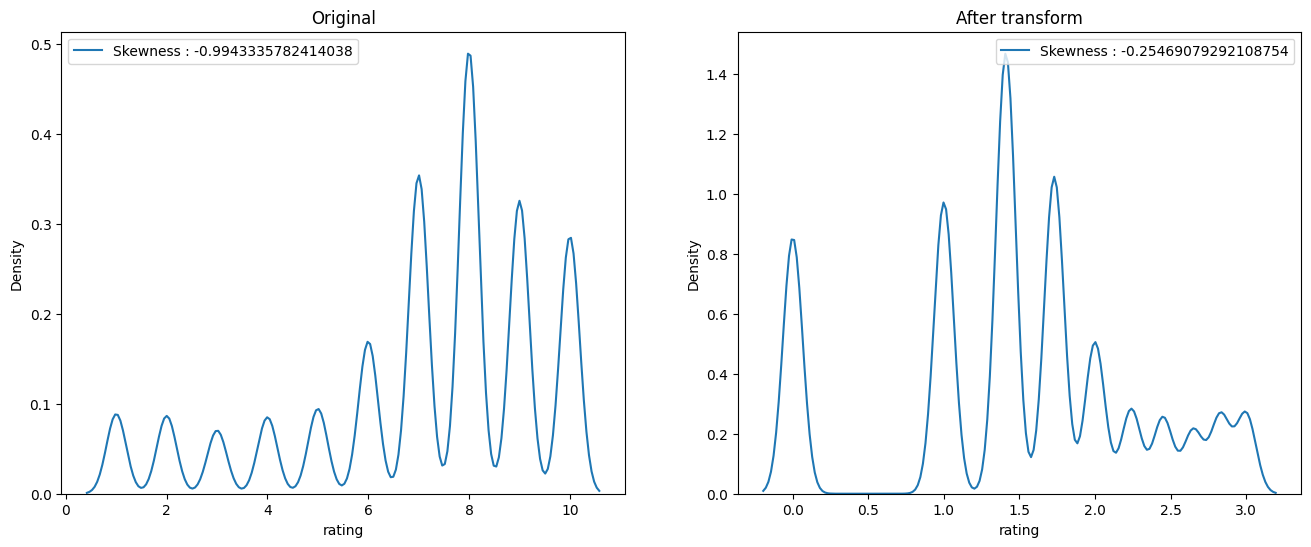

In [11]:
# Explicit Feedback Imbalance

f, ax = plt.subplots(1,2,figsize = (16,6))

# df_train_ratings['rating'].value_counts(True).sort_index().plot.bar(ax = ax[0])
# ax[0].set_title('Original')
# ax[0].legend(['Skewness : {}'.format(df_train_ratings['rating'].skew())])

# df_train_ratings['rating'].apply(lambda x : round(np.sqrt(10 - x), 2)).value_counts(True).sort_index().plot.bar(ax = ax[1])
# ax[1].set_title('After transform')
# ax[1].legend(['Skewness : {}'.format(df_train_ratings['rating'].apply(lambda x : round(np.log1p(10 - x), 2)).skew())])

sns.kdeplot(df_train_ratings['rating'], ax = ax[0])
ax[0].set_title('Original')
ax[0].legend(['Skewness : {}'.format(df_train_ratings['rating'].skew())])

sns.kdeplot(df_train_ratings['rating'].apply(lambda x : round(np.sqrt(10 - x), 2)), ax = ax[1])
ax[1].set_title('After transform')
ax[1].legend(['Skewness : {}'.format(df_train_ratings['rating'].apply(lambda x : round(np.log1p(10 - x), 2)).skew())])

## Users

In [12]:
for column in df_users.columns:
    if column == 'user_id':
        continue
    if df_users[column].dtype == object:
        print(column)
        df_users[column] = df_users[column].apply(str_lower)

location


In [13]:
# Location에도 결측치가 존재할 수 있음을 암시
df_users.head()

,user_id,location,age
0,8,"timmins, ontario, canada",NaN
1,11400,"ottawa, ontario, canada",49.0
2,11676,"n/a, n/a, n/a",NaN
3,67544,"toronto, ontario, canada",30.0
4,85526,"victoria, british columbia, canada",36.0


In [14]:
# Age 결측치
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68092 entries, 0 to 68091
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   68092 non-null  object 
 1   location  68092 non-null  object 
 2   age       40259 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.6+ MB


In [15]:
df_users.isna().mean()

user_id     0.000000
location    0.000000
age         0.408756
dtype: float64

In [16]:
df_users.duplicated().sum()

0

In [17]:
df_users.describe()

,age
count,40259.000000
mean,36.069873
std,13.842571
min,5.000000
25%,25.000000
50%,34.000000
75%,45.000000
max,99.000000


In [18]:
df_users['user_id'].nunique()

68092

In [19]:
df_users['location'] = df_users['location'].apply(lambda x : re.sub(r'[^a-zA-Z,]', '', x))

df_users['location_city'] = df_users['location'].apply(lambda x: x.split(',')[0].strip())
df_users['location_state'] = df_users['location'].apply(lambda x: x.split(',')[1].strip())
df_users['location_country'] = df_users['location'].apply(lambda x: x.split(',')[2].strip())

df_users = df_users.replace('na', np.nan)
df_users = df_users.replace('', np.nan)

In [20]:
df_users['location'] = df_users['location'].apply(lambda x: ','.join(map(str, ['na' if '' == i else i for i in x.split(',')])))

In [21]:
modify_location = set(df_users[(df_users['location_state'].isna()) & ((df_users['location_city'].notnull()))]['location_city'].values)

location_list = []
for location in tqdm(modify_location): # city값은 존재하는데 state가 없는 경우의 city들
    try:
        candidates = df_users[(df_users['location_city']==location) & ((df_users['location_city'].notnull()))]['location'].value_counts()
        first = candidates.idxmax()
        for k, v in dict(candidates).items():
            k = k.split(',')
            if 'na' not in k:
                right_location = ','.join(map(str, k))
                break
        else:
            right_location = first
        location_list.append(right_location)
    except:
        pass

for location in tqdm(location_list): # [지역, 주, 국가]
    df_users.loc[df_users[(df_users['location_city']==location.split(',')[0]) & (df_users['location_state'].isna())].index, 'location_state'] = location.split(',')[1]

# state의 결측치를 country의 정보를 활용해 채워보자
modify_location = set(df_users[(df_users['location_state'].isna()) & ((df_users['location_country'].notnull()))]['location_country'].values)

location_list = []
for location in tqdm(modify_location): # city값은 존재하는데 state가 없는 경우의 city들
    try:
        candidates = df_users[(df_users['location_country']==location) & ((df_users['location_country'].notnull()))]['location'].value_counts()
        first = candidates.idxmax()
        for k, v in dict(candidates).items():
            k = k.split(',')
            if 'na' not in k:
                right_location = ','.join(map(str, k))
                break
        else:
            right_location = first
        location_list.append(right_location)
    except:
        pass

for location in tqdm(location_list): # [지역, 주, 국가]
    df_users.loc[df_users[(df_users['location_country']==location.split(',')[2]) & (df_users['location_state'].isna())].index, 'location_state'] = location.split(',')[1]


## country 채우기
# country의 결측치를 city의 정보를 활용해 채워보자
modify_location = set(df_users[(df_users['location_country'].isna()) & ((df_users['location_city'].notnull()))]['location_city'].values)

location_list = []
for location in tqdm(modify_location): # city값은 존재하는데 state가 없는 경우의 city들
    try:
        candidates = df_users[(df_users['location_city']==location) & ((df_users['location_city'].notnull()))]['location'].value_counts()
        first = candidates.idxmax()
        for k, v in dict(candidates).items():
            k = k.split(',')
            if 'na' not in k:
                right_location = ','.join(map(str, k))
                break
        else:
            right_location = first
        location_list.append(right_location)
    except:
        pass

for location in tqdm(location_list): # [지역, 주, 국가]
    df_users.loc[df_users[(df_users['location_city']==location.split(',')[0]) & (df_users['location_country'].isna())].index, 'location_country'] = location.split(',')[2]

# country의 결측치를 state의 정보를 활용해 채워보자
modify_location = set(df_users[(df_users['location_country'].isna()) & ((df_users['location_state'].notnull()))]['location_state'].values)

location_list = []
for location in tqdm(modify_location): # city값은 존재하는데 state가 없는 경우의 city들
    try:
        candidates = df_users[(df_users['location_state']==location) & ((df_users['location_state'].notnull()))]['location'].value_counts()
        first = candidates.idxmax()
        for k, v in dict(candidates).items():
            k = k.split(',')
            if 'na' not in k:
                right_location = ','.join(map(str, k))
                break
        else:
            right_location = first
        location_list.append(right_location)
    except:
        pass

for location in tqdm(location_list): # [지역, 주, 국가]
    df_users.loc[df_users[(df_users['location_state']==location.split(',')[1]) & (df_users['location_country'].isna())].index, 'location_country'] = location.split(',')[2]


# 남은 결측치는 unknown으로 채우기
df_users[['location_city', 'location_state', 'location_country']] = df_users[['location_city', 'location_state', 'location_country']].fillna('unknown')

# where가 들어간 city, state, country는 다 unknown으로 교체
df_users.loc[df_users[df_users['location_city'].str.contains('where')].index, 'location_city'] = 'unknown'
df_users.loc[df_users[df_users['location_state'].str.contains('where')].index, 'location_state'] = 'unknown'
df_users.loc[df_users[df_users['location_country'].str.contains('where')].index, 'location_country'] = 'unknown'

100%|██████████| 2/2 [00:00<00:00, 127.36it/s]


In [22]:
temp = df_users.groupby('location_city')['location_country'].value_counts().groupby('location_city').idxmax().apply(lambda x : x[-1]).reset_index().rename(columns = {'count':'location_country'})
city2country = dict(zip(temp['location_city'].values, temp['location_country'].values))

df_users['location_country'] = df_users['location_city'].map(city2country)

In [23]:
df_users[df_users['location_city'] == 'seattle']['location_country'].value_counts()

location_country
usa    572
Name: count, dtype: int64

In [24]:
## seattle -> usa

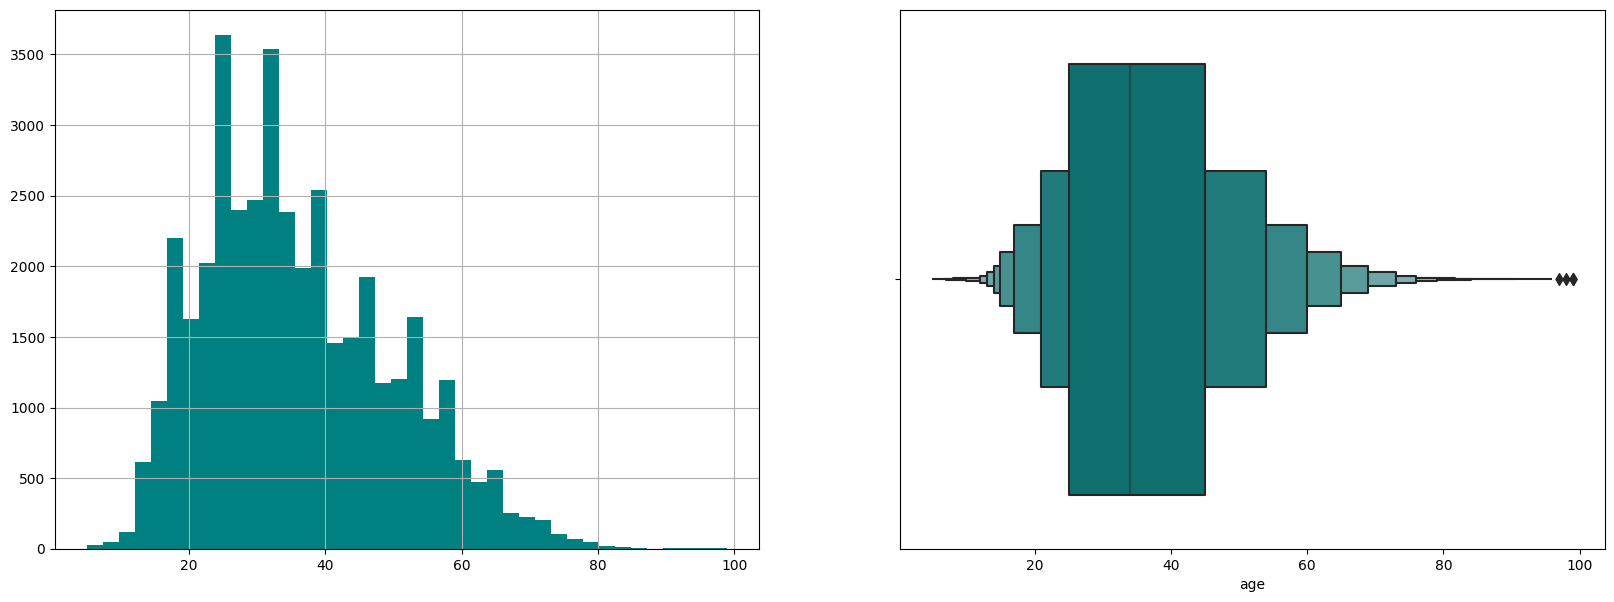

In [25]:
# 나이 분포
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

df_users['age'].hist(bins=40, color='teal', ax=ax[0])
sns.boxenplot(data=df_users, x='age', color='teal',ax=ax[1])

plt.show()

In [26]:
df_users['age'].nunique()

91

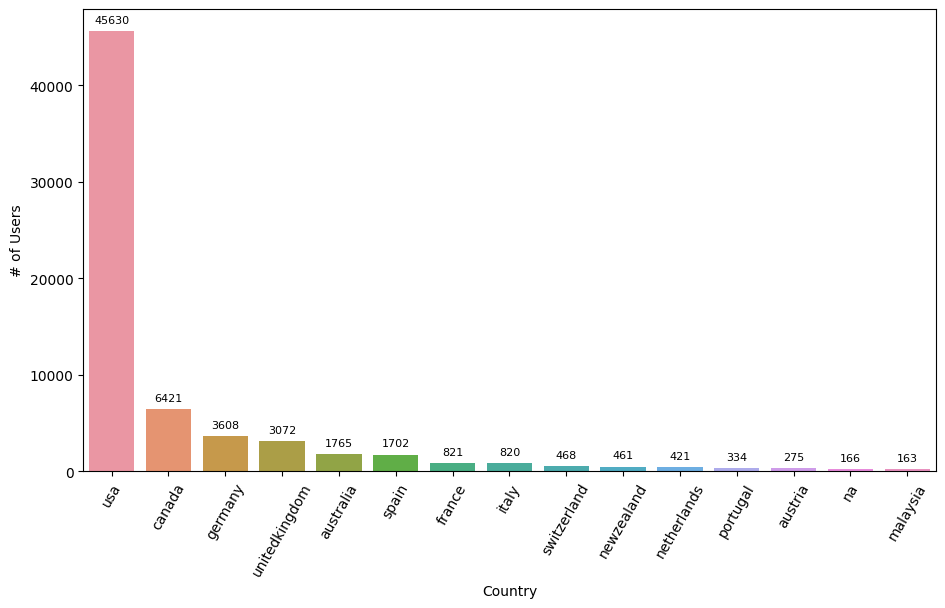

In [27]:
my_dict=(df_users['location_country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['location_country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
# f.drop(7,inplace=True)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'location_country' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show()

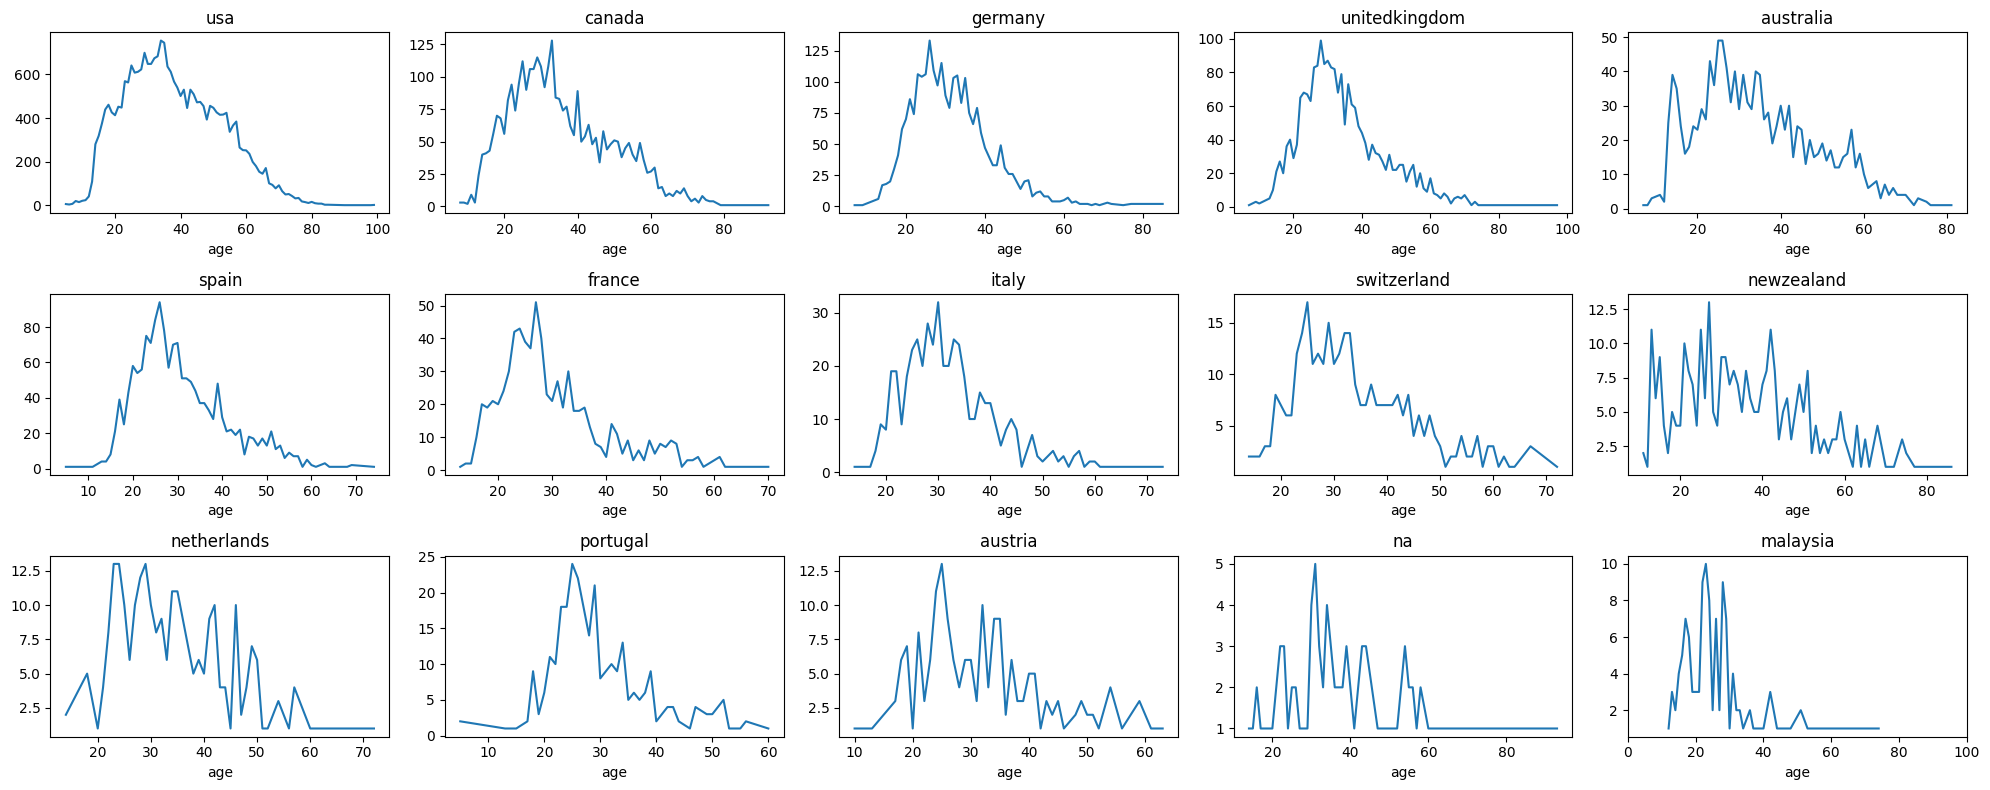

In [28]:
# 20~30대가 많으며 분포 거의 비슷
fig, ax = plt.subplots(3,5,figsize=(20,8))
for country, ax_ in zip(f['location_country'], ax.flatten()):
    df_users[(df_users['location_country']==country)]['age'].value_counts().sort_index().plot(ax=ax_, title=country)
plt.xlim(0,100)
plt.tight_layout()
plt.show()

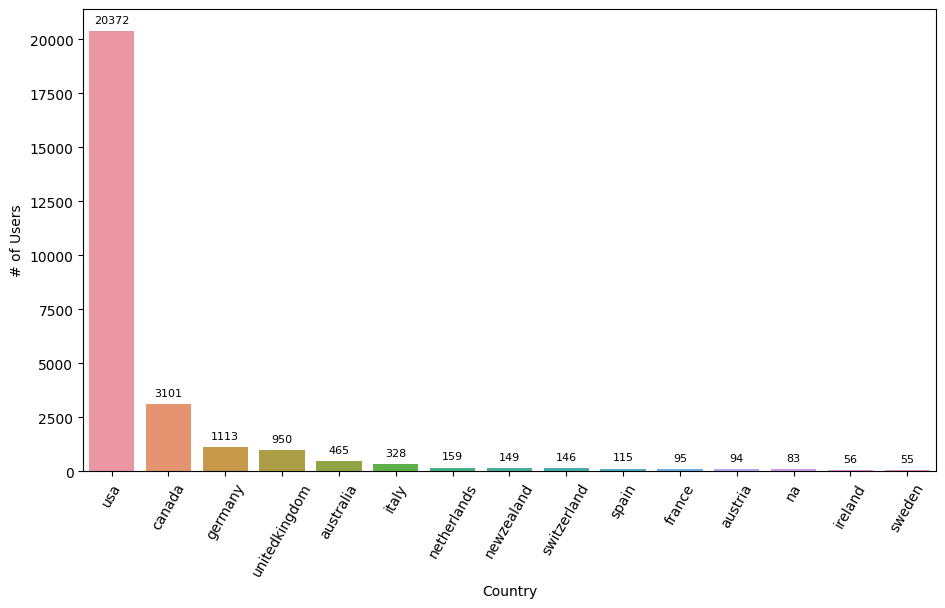

In [29]:
my_dict=(df_users[df_users['age'].isna()]['location_country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['location_country','count'])
f = count.sort_values(by=['count'], ascending = False)
f = f.head(15)
fig=plt.figure(figsize=(11,6))
ax = sns.barplot(y = 'count',x= 'location_country' , data = f)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60,horizontalalignment='center')
for bar in ax.patches: 
    ax.annotate(format(bar.get_height(), '.0f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=8, xytext=(0,8), 
                   textcoords='offset points') 

plt.xlabel("Country", size=10)
plt.ylabel("# of Users", size=10)
plt.show()

In [30]:
# def binning_age(x):
#     if np.isnan(x):
#         return np.nan
    
#     if x < 10:
#         return '0'
    
#     elif 10 <= x < 20:
#         return '10'
    
#     elif 20 <= x < 30:
#         return '20'
    
#     elif 30 <= x < 40:
#         return '30'
    
#     elif 40 <= x < 50:
#         return '40'
    
#     elif 50 <= x < 60:
#         return '50'
    
#     elif 60 <= x < 70:
#         return '60'
    
#     elif 70 <= x < 80:
#         return '70'
    
#     else:
#         return '80'

def binning_age(x):
    if np.isnan(x):
        return np.nan
    
    elif x < 20:
        x = 10
    elif 20 <= x < 30:
        x = 20
    elif 30 <= x < 40:
        x = 30
    elif 40 <= x < 50:
        x = 40
    elif 50 <= x < 60:
        x = 60 
    elif x >= 60:
        x = 60
    return x

# df_users['binning_age'] = df_users['age'].apply(binning_age)

In [31]:
# sns.kdeplot(df_users['binning_age'])

In [32]:
# A: age:nan -> B1 -> age:B1_age
# A  age:nan -> B2 -> age:B2_age

In [33]:
temp = df_train_ratings.merge(df_users, on = 'user_id')
gia = temp.groupby('isbn')['age'].mean()
temp['gia'] = temp['isbn'].map(gia)
grouped_isbn_age_grouped_uid_gia = temp.groupby('user_id')['gia'].mean()
temp['giagua'] = temp['user_id'].map(grouped_isbn_age_grouped_uid_gia)
temp['giagua'].isna().mean()

0.01805766065287896

In [34]:
temp[temp['age'].notnull()][['age', 'giagua']].head(10)

,age,giagua
7,30.0,37.277186
8,30.0,37.277186
9,30.0,37.277186
10,30.0,37.277186
11,30.0,37.277186
12,30.0,37.277186
13,30.0,37.277186
21,60.0,48.568698
22,60.0,48.568698
23,60.0,48.568698


In [35]:
feature2index = dict(zip(temp.columns, range(len(temp.columns))))
temp['final'] = temp.apply(lambda x : x[feature2index['giagua']] if type(x[feature2index['age']]) == float and np.isnan(x[feature2index['age']]) else x[feature2index['age']], axis = 1)
uid2age = dict(zip(temp['user_id'].values, temp['final'].values))

In [36]:
df_users['age'] = df_users['user_id'].map(uid2age)
df_users['binning_age'] = df_users['age'].apply(binning_age)
df_users['binning_age'] = df_users['binning_age'].astype('str')

In [37]:
# df_users = df_users.drop(columns='location')

In [38]:
df_users['age'].isna().mean()

0.1918140163308465

### 떨구기

In [39]:
pwd

'/opt/ml/kys/level1_bookratingprediction-recsys-02'

In [40]:
cd data

/opt/ml/kys/level1_bookratingprediction-recsys-02/data


In [41]:
df_users.isna().sum()

user_id                 0
location                0
age                 13061
location_city           0
location_state          0
location_country        0
binning_age             0
dtype: int64

In [42]:
df_users = df_users.drop(columns='age')
df_users.rename(columns = {'binning_age':'age'},inplace = True)

In [43]:
df_users.isna().sum()

user_id             0
location            0
location_city       0
location_state      0
location_country    0
age                 0
dtype: int64

In [44]:
#csv로 저장 
df_users.to_csv(data_path + '/users_1.csv', index=False)

## Books

In [103]:
for column in df_books.columns:
    if column == 'isbn':
        continue
    if df_books[column].dtype == object:
        print(column)
        df_books[column] = df_books[column].apply(str_lower)

book_title
book_author
publisher
img_url
language
category
summary
img_path


In [104]:
df_books.head()

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path
0,0002005018,clara callan,richard bruce wright,2001.0,harperflamingo canada,http://images.amazon.com/images/p/0002005018.0...,en,['actresses'],"in a small town in canada, clara callan reluct...",images/0002005018.01.thumbzzz.jpg
1,0060973129,decision in normandy,carlo d'este,1991.0,harperperennial,http://images.amazon.com/images/p/0060973129.0...,en,['1940-1949'],"here, for the first time in paperback, is an o...",images/0060973129.01.thumbzzz.jpg
2,0374157065,flu: the story of the great influenza pandemic...,gina bari kolata,1999.0,farrar straus giroux,http://images.amazon.com/images/p/0374157065.0...,en,['medical'],"describes the great flu epidemic of 1918, an o...",images/0374157065.01.thumbzzz.jpg
3,0399135782,the kitchen god's wife,amy tan,1991.0,putnam pub group,http://images.amazon.com/images/p/0399135782.0...,en,['fiction'],a chinese immigrant who is convinced she is dy...,images/0399135782.01.thumbzzz.jpg
4,0425176428,what if?: the world's foremost military histor...,robert cowley,2000.0,berkley publishing group,http://images.amazon.com/images/p/0425176428.0...,en,['history'],"essays by respected military historians, inclu...",images/0425176428.01.thumbzzz.jpg


In [105]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149570 entries, 0 to 149569
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   isbn                 149570 non-null  object 
 1   book_title           149570 non-null  object 
 2   book_author          149569 non-null  object 
 3   year_of_publication  149570 non-null  float64
 4   publisher            149570 non-null  object 
 5   img_url              149570 non-null  object 
 6   language             82343 non-null   object 
 7   category             80719 non-null   object 
 8   summary              82343 non-null   object 
 9   img_path             149570 non-null  object 
dtypes: float64(1), object(9)
memory usage: 11.4+ MB


In [106]:
df_books.isna().mean()

isbn                   0.000000
book_title             0.000000
book_author            0.000007
year_of_publication    0.000000
publisher              0.000000
img_url                0.000000
language               0.449468
category               0.460326
summary                0.449468
img_path               0.000000
dtype: float64

In [107]:
df_books['publisher'].nunique()

11428

In [108]:
df_books['pnumber'] = df_books['isbn'].apply(lambda x : x[:3])

In [109]:
# df_books['pnumber'].value_counts().reset_index().groupby('count').count().reset_index().head(20)

In [110]:
# sup_pnumber = 20
# temp = df_books['pnumber'].value_counts()
# limit_pnumber = temp[temp < sup_pnumber].index

# df_books.loc[df_books['pnumber'].isin(limit_pnumber), 'pnumber'] = 'other'
# df_books['pnumber'].nunique()

In [111]:
df_books.loc[df_books[df_books['category'].notnull()].index, 'category'] = df_books[df_books['category'].notnull()]['category'].apply(lambda x: re.sub('[\W_]+',' ',x).lower().strip())

In [112]:
# 1.저자 2.출판사를 따라가지 않으까?
df_books['category'].isna().mean()

0.4603262686367587

In [113]:
temp = df_books.groupby('book_author')['category'].value_counts().groupby('book_author').idxmax().apply(lambda x : x[-1])# .reset_index().rename(columns = {'count' : 'language'})
temp = defaultdict(lambda : np.nan, temp.to_dict())

In [114]:
feature2index = dict(zip(df_books.columns, range(len(df_books.columns))))
df_books['category'] = df_books.apply(lambda x : temp[x[feature2index['book_author']]] if type(x[feature2index['category']]) == float and np.isnan(x[feature2index['category']]) else x[feature2index['category']], axis = 1)

In [115]:
df_books['category'].isna().mean()

0.17736177040850437

In [116]:
temp = df_books.groupby('pnumber')['category'].value_counts().groupby('pnumber').idxmax().apply(lambda x : x[-1])# .reset_index().rename(columns = {'count' : 'language'})
temp = defaultdict(lambda : np.nan, temp.to_dict())

In [117]:
feature2index = dict(zip(df_books.columns, range(len(df_books.columns))))
df_books['category'] = df_books.apply(lambda x : temp[x[feature2index['pnumber']]] if type(x[feature2index['category']]) == float and np.isnan(x[feature2index['category']]) else x[feature2index['category']], axis = 1)

In [118]:
df_books['category'].isna().mean()

0.0009360165808651468

In [119]:
words = defaultdict(int)
for value in df_books['category'].values:
    try:
        if len(value.split()) == 1:
            words[value] += 1
    except:
        pass
print(len(words))
categories = [(value, key) for key,value in words.items()]
categories.sort(reverse = True)

1270


In [120]:
df_books['category'].value_counts()

category
fiction                                            82556
juvenile fiction                                   10587
biography autobiography                             4534
history                                             2467
religion                                            2389
                                                   ...  
coasts                                                 1
electronic journals                                    1
romania                                                1
aeronautics military                                   1
authors canadian english 20th century biography        1
Name: count, Length: 4105, dtype: int64

In [121]:
for _, category in categories:
    df_books.loc[df_books[df_books['category'].str.contains(category,na=False)].index,'category_high'] = category

In [122]:
df_books['category_high'].isna().mean()

0.03248646118874106

In [123]:
df_books['category_high'].value_counts()

category_high
fiction          95594
autobiography     4538
science           2915
history           2490
religion          2390
                 ...  
coasts               1
disguise             1
dogsledding          1
hyperspace           1
deafness             1
Name: count, Length: 1197, dtype: int64

In [124]:
# 출판사를 따라가지 않을까?
print(df_books['language'].isna().mean())

0.449468476298723


In [125]:
temp = df_books.groupby('pnumber')['language'].value_counts().groupby('pnumber').idxmax().apply(lambda x : x[-1])# .reset_index().rename(columns = {'count' : 'language'})
temp = defaultdict(lambda : np.nan, temp.to_dict())

In [126]:
feature2index = dict(zip(df_books.columns, range(len(df_books.columns))))
df_books['language'] = df_books.apply(lambda x : temp[x[feature2index['pnumber']]] if type(x[feature2index['language']]) == float and np.isnan(x[feature2index['language']]) else x[feature2index['language']], axis = 1)

In [127]:
print(df_books['language'].isna().mean())

0.001785117336364244


In [128]:
# en vs else

In [129]:
df_users.isna().sum()

user_id             0
location            0
location_city       0
location_state      0
location_country    0
age                 0
dtype: int64

<Axes: xlabel='year_of_publication', ylabel='Density'>

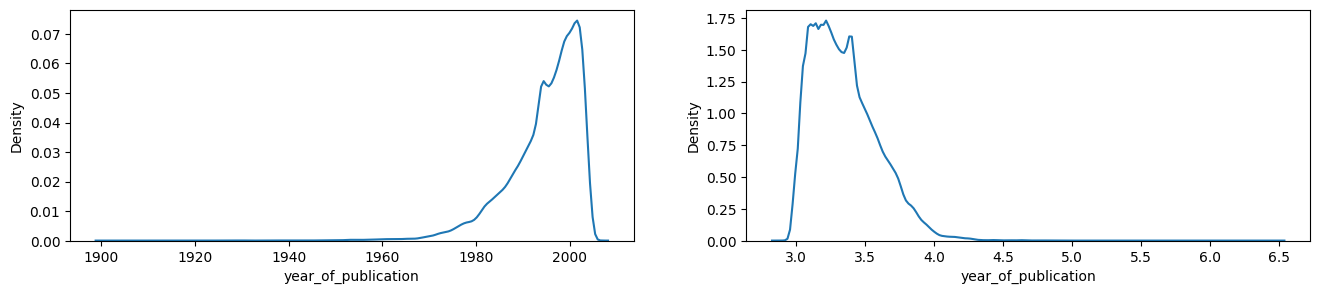

In [130]:
# 1. 현재(2023)부터 얼마나 오래된 책인지, 2. log transform을 통해 sknewss 완화 3. 오랜된 책은 한번에 묶어주기(Binning)
f, ax = plt.subplots(1,2, figsize = (16, 3))

sns.kdeplot(df_books[df_books['year_of_publication'] > 1900]['year_of_publication'], ax = ax[0])
sns.kdeplot(df_books['year_of_publication'].apply(lambda x : np.log1p(2023 - x)), ax = ax[1])

0.6522555632345214


<Axes: xlabel='log_year_of_publication', ylabel='Density'>

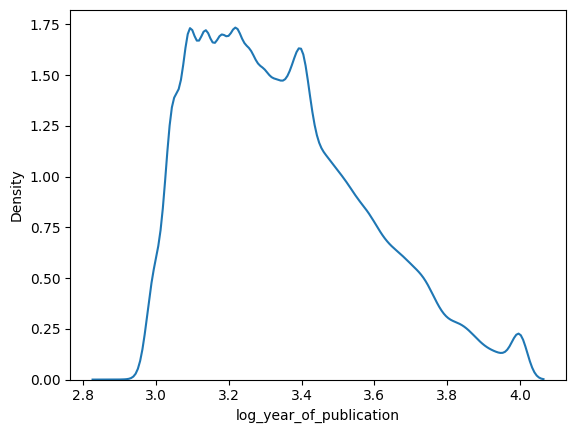

In [131]:
sup = 4

df_books['log_year_of_publication'] = df_books['year_of_publication'].apply(lambda x : np.log1p(2023 - x))
df_books['log_year_of_publication'] = df_books['log_year_of_publication'].apply(lambda x : x if x < sup else sup)

print(df_books['log_year_of_publication'].skew())
sns.kdeplot(df_books['log_year_of_publication'])

In [132]:
def binning_year(x):
    if x < 1970:
        return '1970'
    elif 1970 <= x < 1980:
        return '1980'
    elif 1980 <= x < 1990:
        return '1990'
    elif 1990 <= x < 2000:
        return '2000'
    else:
        return 'Early'

df_books['binning_year'] = df_books['year_of_publication'].apply(binning_year)

In [133]:
df_books['book_title'].value_counts()

book_title
the secret garden                                        19
selected poems                                           16
little women                                             16
dracula                                                  16
adventures of huckleberry finn                           15
                                                         ..
graceland : a novel                                       1
another world                                             1
tiden det tar: roman                                      1
a folk weather calendar (what will the weather be, 1)     1
dallas street map guide and directory, 2000 edition       1
Name: count, Length: 134011, dtype: int64

In [134]:
# Frances Hodgson Burnett
# Frances H. Burnett

In [135]:
df_books[df_books['book_title'] == 'the secret garden']

,isbn,book_title,book_author,year_of_publication,publisher,img_url,language,category,summary,img_path,pnumber,category_high,log_year_of_publication,binning_year
5098,0812505018,the secret garden,frances hodgson burnett,1989.0,tor books,http://images.amazon.com/images/p/0812505018.0...,en,fiction,"an orphan, sent from india to england to live ...",images/0812505018.01.thumbzzz.jpg,081,fiction,3.555348,1990
11516,0590433466,the secret garden,frances h. burnett,1997.0,scholastic,http://images.amazon.com/images/p/0590433466.0...,en,juvenile fiction,NaN,images/0590433466.01.thumbzzz.jpg,059,fiction,3.295837,2000
13601,006440188X,the secret garden,frances hodgson burnett,1998.0,harpertrophy,http://images.amazon.com/images/p/006440188x.0...,en,juvenile fiction,&quot;one of th&#39; gardens is locked up.,images/006440188x.01.thumbzzz.jpg,006,fiction,3.258097,2000
20350,0440977096,the secret garden,frances hodgson burnett,1989.0,laure leaf,http://images.amazon.com/images/p/0440977096.0...,en,juvenile fiction,ten-year-old mary comes to live in a lonely ho...,images/0440977096.01.thumbzzz.jpg,044,fiction,3.555348,1990
22930,0879236493,the secret garden,frances hodgson burnett,1987.0,david r. godine publisher,http://images.amazon.com/images/p/0879236493.0...,en,juvenile fiction,the robin helps mary find the door to the secr...,images/0879236493.01.thumbzzz.jpg,087,fiction,3.610918,1990
37322,0590471724,the secret garden,m.j. carr,1993.0,scholastic paperbacks (mm),http://images.amazon.com/images/p/0590471724.0...,en,gardens,a young orphan discovers a whole new world whe...,images/0590471724.01.thumbzzz.jpg,059,gardens,3.433987,2000
51248,055321201X,the secret garden,frances h. burnett,1987.0,bantam,http://images.amazon.com/images/p/055321201x.0...,en,juvenile fiction,ten-year-old mary comes to live in a lonely ho...,images/055321201x.01.thumbzzz.jpg,055,fiction,3.610918,1990
51414,0439099390,the secret garden,frances hodgson burnett,1999.0,scholastic,http://images.amazon.com/images/p/0439099390.0...,en,juvenile fiction,a ten-year-old orphan comes to live in a lonel...,images/0439099390.01.thumbzzz.jpg,043,fiction,3.218876,2000
55931,0440777062,the secret garden,frances hodgson burnett,1979.0,dell publishing,http://images.amazon.com/images/p/0440777062.0...,en,children with disabilities,ten-year-old mary comes to live in a lonely ho...,images/0440777062.01.thumbzzz.jpg,044,children,3.806662,1980
59407,0397306326,the secret garden,frances hodgson burnett,1985.0,lippincott,http://images.amazon.com/images/p/0397306326.0...,en,children with disabilities,ten-year-old mary comes to live in a lonely ho...,images/0397306326.01.thumbzzz.jpg,039,children,3.663562,1990


In [136]:
df_users.isna().mean()

user_id             0.0
location            0.0
location_city       0.0
location_state      0.0
location_country    0.0
age                 0.0
dtype: float64

In [137]:
df_books.isna().mean()

isbn                       0.000000
book_title                 0.000000
book_author                0.000007
year_of_publication        0.000000
publisher                  0.000000
img_url                    0.000000
language                   0.001785
category                   0.000936
summary                    0.449468
img_path                   0.000000
pnumber                    0.000000
category_high              0.032486
log_year_of_publication    0.000000
binning_year               0.000000
dtype: float64

(0.0, 11.0)

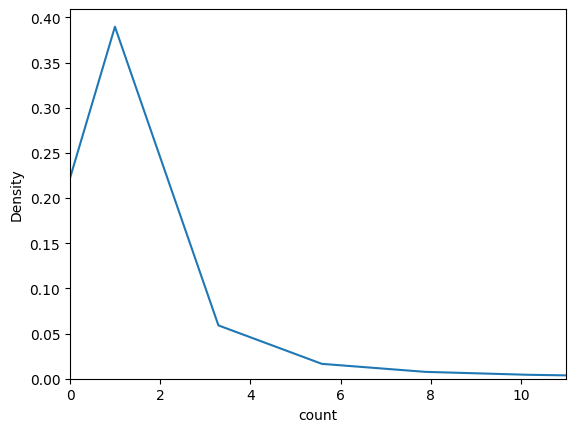

In [138]:
sns.kdeplot(df_books['book_author'].value_counts())
plt.xlim([0,11])

### 떨구기


In [139]:
df_books.isna().sum()

isbn                           0
book_title                     0
book_author                    1
year_of_publication            0
publisher                      0
img_url                        0
language                     267
category                     140
summary                    67227
img_path                       0
pnumber                        0
category_high               4859
log_year_of_publication        0
binning_year                   0
dtype: int64

In [140]:
df_books = df_books.drop(columns='year_of_publication')
df_books = df_books.drop(columns='category')
df_books = df_books.drop(columns='publisher')
df_books.rename(columns = {'binning_year':'year_of_publication'},inplace = True)
df_books.rename(columns = {'category_high':'category'},inplace = True)
df_books.rename(columns = {'pnumber':'publisher'},inplace = True)

In [141]:
df_books.isna().sum()

isbn                           0
book_title                     0
book_author                    1
img_url                        0
language                     267
summary                    67227
img_path                       0
publisher                      0
category                    4859
log_year_of_publication        0
year_of_publication            0
dtype: int64

In [142]:
#csv로 저장 
df_books.to_csv(data_path + '/books_1.csv', index=False)

## merge

In [ ]:
# sup_author = 3
# temp = df_books['book_author'].value_counts()
# limit_author = temp[temp < sup_author].index
# df_books.loc[df_books['book_author'].isin(limit_author), 'book_author'] = 'other'
# print(df_books['book_author'].nunique() / len(df_books))

In [ ]:
temp = df_train_ratings.merge(df_books, how='left', on='isbn')
data = temp.merge(df_users, how='left', on='user_id')
print('merge 결과 shape: ', data.shape)

In [ ]:
data.head()

In [ ]:
data.isna().mean()

In [ ]:
data.nunique() / len(data)

In [ ]:
print(data.groupby('user_id')['rating'].var().isna().sum())
sns.kdeplot(data.groupby('user_id')['rating'].var())
plt.xlabel('group(user_id).var() in data')

In [ ]:
temp = data.copy()
temp['loged_rating'] = temp['rating'].apply(lambda x : round(np.log1p(10 - x), 2))
sns.kdeplot(temp.groupby('user_id')['loged_rating'].var())

In [ ]:
temp = data.copy()
temp['loged_rating'] = temp['rating'].apply(lambda x : round(np.log1p(x), 2))
sns.kdeplot(temp.groupby('user_id')['loged_rating'].var())

In [ ]:
temp = data.copy()
temp['loged_rating'] = temp['rating'].apply(lambda x : round(np.sqrt(x), 2))
sns.kdeplot(temp.groupby('user_id')['loged_rating'].var())

In [ ]:
sns.kdeplot(data.groupby('book_author')['rating'].var())

In [ ]:
sns.kdeplot(data.groupby('category')['rating'].var())

In [ ]:
sns.kdeplot(data.groupby('user_id')['rating'].mean())

In [ ]:
sns.kdeplot(x = 'rating', data = data[data['user_id'].isin(['11676', '98391', '189835'])], hue = 'user_id', common_norm = False)

In [ ]:
sns.kdeplot(x = 'rating', data = data[data['book_author'].isin(['stephen king', 'john grisham', 'nora roberts'])], hue = 'book_author', common_norm = False)

In [ ]:
# temp = data['user_id'].value_counts()
# removed = temp[temp == 1].index
# data = data[~(data['user_id'].isin(removed))]

In [ ]:
rating_var = data.groupby('user_id')['rating'].var().rename('rating_var')
data = data.merge(rating_var, on = 'user_id')
data['rating_var'].fillna(value = 0.0, inplace = True)

data = data[['rating', 'user_id', 'isbn', 'book_author', 'language', 'category','pnumber', 'binning_year','age', 'location_city', 'location_state', 'location_country', 'book_title']]
# data = data[['rating', 'user_id', 'isbn', 'book_author', 'language', 'category_high','pnumber', 'binning_year','binning_age', 'location_city', 'location_state', 'location_country', 'book_title', 'rating_var']]

data['book_author'] = data['book_author'].fillna(value = 'other')
data['language'] = data['language'].fillna(value = 'other')
data['binning_year'] = data['binning_year'].fillna(value = 'other')
data['category'] = data['category'].fillna(value = 'other')
data['age'] = data['age'].fillna(value = 'other')
data['location_city'] = data['location_city'].fillna(value = 'other')
data['location_state'] = data['location_state'].fillna(value = 'other')
data['location_country'] = data['location_country'].fillna(value = 'other')
data['book_title'] = data['book_title'].fillna(value = 'other')

In [ ]:
X = data.drop('rating', axis = 1)
categorical_features_indices = np.where(X.dtypes == object)[0]
print(categorical_features_indices)
y = data['rating']
transformed_y = data['rating'].apply(lambda x : round(np.log1p(x), 2))

In [ ]:
df_users.isna().sum()

In [ ]:
def rmse(y, y_pred):
    return mean_squared_error(y, y_pred, squared = False)

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)
parms = {'verbose' : 0, 'cat_features' : categorical_features_indices}
# parms = {'verbose' : 0, 'cat_features' : categorical_features_indices, 'task_type' : 'GPU'}
# parms = {'verbose' : 0, 'cat_features' : categorical_features_indices, 'task_type' : 'GPU', 'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}
# parms = {'verbose' : 0, 'cat_features' : categorical_features_indices, 'task_type' : 'GPU', 'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}
creg = CatBoostRegressor(**parms)
creg.fit(X, y)
y_pred = creg.predict(X)
print(creg.__class__.__name__)
print(rmse(y, y_pred))

creg_val = cross_val_score(creg, X, y, cv = cv, scoring = make_scorer(rmse))
print('val acc :', creg_val.mean())

result = list(zip(creg.get_feature_importance(), X.columns))
result.sort(reverse = True)
print(result)

In [ ]:
y_pred = creg.predict(X)
print(creg.__class__.__name__)
print(rmse(y, y_pred))

In [ ]:
def transformed_rmse(y, y_pred):
    return mean_squared_error(np.expm1(y), np.expm1(y_pred), squared = False)

n_splits = 5
tcv = KFold(n_splits=n_splits, random_state=42, shuffle=True)
parms = {'verbose' : 0, 'cat_features' : categorical_features_indices, 'task_type' : 'GPU'}
# parms = {'verbose' : 0, 'cat_features' : categorical_features_indices, 'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}
tcreg = CatBoostRegressor(**parms)
tcreg.fit(X, transformed_y)
y_pred = tcreg.predict(X)
print(tcreg.__class__.__name__)
print(transformed_rmse(transformed_y, y_pred))

tcreg_val = cross_val_score(tcreg, X, transformed_y, cv = tcv, scoring = make_scorer(transformed_rmse))
print('val acc :', tcreg_val.mean())

result = list(zip(tcreg.get_feature_importance(), X.columns))
result.sort(reverse = True)
print(result)

# CatBoostRegressor
# 1.8069759242202001
# val acc : 2.211108931441629
# [(43.97826739051024, 'user_id'), (16.67759823326652, 'book_author'), (7.49981870533629, 'pnumber'), (6.339808661048036, 'book_title'), (4.167853990360564, 'binning_age'), (4.053608706155662, 'location_city'), 
#  (3.981358070586581, 'category_high'), (3.857726915637237, 'binning_year'), (3.4852310244140896, 'location_state'), (3.3688383268608515, 'location_country'), (1.6734995264966097, 'language'), (0.9163904493273056, 'isbn')]

# CatBoostRegressor
# 1.608484921227248
# val acc : 2.1755318773315757
# [(42.24482005957925, 'user_id'), (16.949893486601454, 'book_author'), (8.08768767958771, 'pnumber'), (6.668057079755238, 'book_title'), (4.432894372154812, 'binning_age'), (4.331932860997784, 'location_city'), (3.931667696269988, 'location_state'), (3.442908864793826, 'binning_year'), (3.3648506123093767, 'category_high'), (2.992731218288474, 'location_country'), (2.3613958676836164, 'language'), (1.1911602019785035, 'isbn')]

In [ ]:
tcreg.get_all_params()

In [ ]:
cat_encoder = ce.cat_boost.CatBoostEncoder()
cat_encoder.fit(X, y)
X = cat_encoder.transform(X)

In [ ]:
lreg = LGBMRegressor()
lreg.fit(X, y)
y_pred = lreg.predict(X)
print(lreg.__class__.__name__)
print(rmse(y, y_pred))

lreg_val = cross_val_score(lreg, X, y, cv = cv, scoring = make_scorer(rmse))
print('val acc :', lreg_val.mean())

# result = list(zip(lreg.get_feature_importance(), X.columns))
# result.sort(reverse = True)
# print(result)

In [ ]:
xreg = XGBRegressor(objective='reg:squarederror')
xreg.fit(X, y)
y_pred = xreg.predict(X)
print(xreg.__class__.__name__)
print(rmse(y, y_pred))

xreg_val = cross_val_score(xreg, X, y, cv = cv, scoring = make_scorer(rmse))
print('val acc :', xreg_val.mean())

# result = list(zip(xreg.get_feature_importance(), X.columns))
# result.sort(reverse = True)
# print(result)

In [ ]:
pwd

In [ ]:
path = '/opt/ml'
data_path = path + '/data'
sample_submission_path = data_path + '/sample_submission.csv'

In [ ]:
df_sample_submission = pd.read_csv(sample_submission_path)
df_sample_submission['user_id'] = df_sample_submission['user_id'].astype(str)

In [ ]:
df_sample_submission.head()

In [ ]:
temp = df_sample_submission.merge(df_books, how='left', on='isbn')
data = temp.merge(df_users, how='left', on='user_id')
print('merge 결과 shape: ', data.shape)
data.head()

In [ ]:
data = data.merge(rating_var, how='left', on = 'user_id')
data['rating_var'].fillna(value = 0.0, inplace = True)

data = data[['rating', 'user_id', 'isbn', 'book_author', 'language', 'category_high','pnumber', 'binning_year','binning_age', 'location_city', 'location_state', 'location_country', 'book_title']]
# data = data[['rating', 'user_id', 'isbn', 'book_author', 'language', 'category_high','pnumber', 'binning_year','binning_age', 'location_city', 'location_state', 'location_country', 'book_title', 'rating_var']]

data['book_author'] = data['book_author'].fillna(value = 'other')
data['language'] = data['language'].fillna(value = 'other')
data['binning_year'] = data['binning_year'].fillna(value = 'other')
data['category_high'] = data['category_high'].fillna(value = 'other')
data['binning_age'] = data['binning_age'].fillna(value = 'other')
data['location_city'] = data['location_city'].fillna(value = 'other')
data['location_state'] = data['location_state'].fillna(value = 'other')
data['location_country'] = data['location_country'].fillna(value = 'other')
data['book_title'] = data['book_title'].fillna(value = 'other')

In [ ]:
X = data.drop('rating', axis = 1)
c_pred = creg.predict(X)
# tc_pred = np.expm1(tcreg.predict(X))

In [ ]:
X = cat_encoder.transform(X)
l_pred = lreg.predict(X)
x_pred = xreg.predict(X)

y_pred = 0.4 * l_pred + 0.3 * c_pred + 0.3 * x_pred

In [ ]:
# df_sample_submission['rating'] = y_pred
df_sample_submission['rating'] = c_pred

In [ ]:
df_sample_submission.head()

In [ ]:
df_users.isna().sum()

In [ ]:
df_sample_submission['rating'].isna().sum()

In [ ]:
df_sample_submission.to_csv(data_path + '/submission.csv', index=False)

In [ ]:
sns.kdeplot(df_sample_submission['rating'])

In [ ]:
# target label transform은 성능 떨어짐(train : 2.18 -> 2.29)
# Age Binning 구간은 성능 차이 없음
# Cardinality 축소도 성능 차이 없음
# Feature Selection은 신중히 하자

# Overfiting, Top-Ranker

In [ ]:
# 2.1242165243553117 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}
# 2.1233636361569754 and parameters: {'learning_rate': 0.10952662748632554, 'bagging_temperature': 0.03613894271216528, 'n_estimators': 3629, 'max_depth': 8, 'random_strength': 46, 'l2_leaf_reg': 2.355742708217648e-05, 'min_child_samples': 24, 'max_bin': 354, 'od_type': 'IncToDec'}
# 2.124190588122351 and parameters: {'learning_rate': 0.016119044727609194, 'bagging_temperature': 0.9565499215943827, 'n_estimators': 1309, 'max_depth': 15, 'random_strength': 26, 'l2_leaf_reg': 1.987904330777592e-05, 'min_child_samples': 34, 'max_bin': 356, 'od_type': 'IncToDec'}
# 2.1213700377152285 and parameters: {'learning_rate': 0.04574578205475402, 'bagging_temperature': 0.12172958098369972, 'n_estimators': 8459, 'max_depth': 8, 'random_strength': 28, 'l2_leaf_reg': 1.6285455533915874e-05, 'min_child_samples': 18, 'max_bin': 441, 'od_type': 'Iter'}